# Control Co-Design of Power Take-off Systems for Wave Energy Converters using WecOptTool
Carlos A. **Michelén Ströfer**, Daniel T. **Gaebele**, Ryan G. **Coe**, and Giorgio **Bacelli** (Member IEEE)

IEEE Transactions on Sustainable Energy, October 2023

DOI: 10.1109/TSTE.2023.3272868

In [1]:
import autograd.numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import capytaine as cpy
import mhkit.wave.resource as mhkit
from mhkit.wave.io import ndbc
import pandas as pd
import string
from sklearn.cluster import KMeans
from datetime import datetime
from scipy.optimize import brute

import wecopttool as wot

## Section III: Verification
#### WecOptTool results

In [2]:
# Capytaine floating body
mesh = wot.geom.WaveBot().mesh(mesh_size_factor = 0.48)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")
ndof = fb.nb_dofs

# mass and stiffness
stiffness = wot.hydrostatics.stiffness_matrix(fb).values
mass = wot.hydrostatics.inertia_matrix(fb).values

# frequency vector
nfreq = 30 
f1 = 0.9/nfreq 
freq = wot.frequency(f1, nfreq, False)
omega = freq * 2*np.pi

# run Capytaine (BEM) 
bem_data = wot.run_bem(fb, freq)
# create WEC object
wec = wot.WEC.from_bem(
    bem_data, 
    inertia_matrix=mass, 
    hydrostatic_stiffness=stiffness,
    constraints=None,
    friction=None,
    f_add=None,
)

# PTO impedance
def pto_impedance(drivetrain_inertia=2.0, drivetrain_stiffness = 0.0):
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_friction = 1.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + -1j/(omega)*drivetrain_stiffness)
    
    winding_impedance = winding_resistance + 1j*omega*winding_inductance

    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance_mat = np.array([[pto_impedance_11, pto_impedance_12],
                              [pto_impedance_21, pto_impedance_22]])
    return pto_impedance_mat


# regular wave
amplitude = 0.0625  
wavefreq = 0.3
waves_reg = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)

# irregular wave
Te = 7.62
gamma = 3.3
fp = 1 / mhkit.energy_period_to_peak_period(Te, gamma)
hs = 1.5
spectrum = lambda f: wot.waves.jonswap_spectrum(f, fp, hs, gamma)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "JONSWAP")
waves_irreg = wot.waves.long_crested_wave(efth)

nsubsteps = 5

# solve
def verification(controller, scale_x_opt, nstate_opt, waves):
    # PTO
    pto = wot.pto.PTO(
        fb.nb_dofs, 
        np.eye(fb.nb_dofs), 
        controller, 
        pto_impedance(), 
        None, 
        ["PTO_Heave"],
    )
    # WEC additional forces
    wec.forces['PTO'] = pto.force_on_wec
    # objective function
    objective = pto.average_power
    # optimal controller
    results = wec.solve(waves, objective, nstate_opt, scale_x_opt=scale_x_opt)
    # post-process
    pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)
    results = {
        'results': results,
        'pto_fdom': pto_fdom, 
        'pto_tdom': pto_tdom, 
        'wec_fdom': wec_fdom, 
        'wec_tdom': wec_tdom}
    return results

# results
print("\nUnstructured, regular wave")
verification_untructured_regular = verification(None, 1e-2, 2*nfreq+1, waves_reg)

print("\nUnstructured, irregular wave")
verification_untructured_irregular = verification(None, 1e-2, 2*nfreq+1, waves_irreg)

print("\nPI, regular wave")
verification_PI_regular = verification(wot.pto.controller_pi, 1e-2, 2, waves_reg)


Unstructured, regular wave
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.188604815732777
            Iterations: 26
            Function evaluations: 48
            Gradient evaluations: 26

Unstructured, irregular wave
Optimization terminated successfully    (Exit mode 0)
            Current function value: -647.7182921948604
            Iterations: 27
            Function evaluations: 51
            Gradient evaluations: 27

PI, regular wave
Optimization terminated successfully    (Exit mode 0)
            Current function value: -29.18860493320121
            Iterations: 45
            Function evaluations: 53
            Gradient evaluations: 45


#### Theoretical results

In [3]:
# regular wave
## PTO impedance, WEC impedance, excitation forces
Fe_reg = (verification_PI_regular['wec_fdom'].sel(type = 'Froude_Krylov').force 
          + verification_PI_regular['wec_fdom'].sel(type = 'diffraction').force
         ).sel(influenced_dof = 'DOF_0')
hydro_data = wot.linear_hydrodynamics(bem_data, mass, stiffness)
Zi = wot.hydrodynamic_impedance(hydro_data).sel(influenced_dof='Heave', radiating_dof='Heave')

## Complex conjugate solution
def thevenin_equivalent(intrinsic_impedance, pto_impedance, excitation_force):
    Z_11 = pto_impedance[0, 0, :]
    Z_12 = pto_impedance[0, 1, :]
    Z_21 = pto_impedance[1, 0, :]
    Z_22 = pto_impedance[1, 1, :]
    V_th =  Z_21 / (-Z_11 + intrinsic_impedance) * excitation_force  # Equation (19)  
    Z_th = Z_22 + (Z_12*Z_21) / (-Z_11 + intrinsic_impedance)  # Equation (20)
    return V_th, Z_th

def complex_conjugate_solution(thev_voltage, thev_impedance):
    thev_current_opt = thev_voltage / (2*thev_impedance.real)
    cc_current = -1.0 *  thev_current_opt # Equation (21)    
    cc_voltage = thev_impedance.conj() * thev_current_opt  # Equation (22)
    return cc_current, cc_voltage

V_th_reg, Z_th =  thevenin_equivalent(Zi, pto_impedance(), Fe_reg)
cc_current_fd_reg, cc_voltage_fd_reg = complex_conjugate_solution(V_th_reg, Z_th)

# Equation (23) >>>
cc_velocity_fd = np.zeros(nfreq) *0j
cc_force_fd = np.zeros(nfreq) * 0j
for ifreq in range(nfreq):
    abcd_inv = np.linalg.inv(wot.pto._make_abcd(pto_impedance(), fb.nb_dofs)[:, :, ifreq])
    vec_elec = np.array([[cc_current_fd_reg[ifreq]], [cc_voltage_fd_reg[ifreq]]])
    vec_mech = abcd_inv @ vec_elec
    cc_velocity_fd[ifreq] = vec_mech[0, 0]
    cc_force_fd[ifreq] = vec_mech[1, 0]
cc_velocity_fd = xr.DataArray(cc_velocity_fd, dims=["omega"], coords=[("omega", omega),],)
cc_force_fd = xr.DataArray(cc_force_fd, dims=["omega"], coords=[("omega", omega), ],)
# Equation (23) <<<
C_cc = cc_force_fd/cc_velocity_fd  # Equation (26)
# Equation (27) >>>
wave_frequency = waves_reg.attrs.get('Frequency (Hz)')
wave_index = C_cc.omega.values.tolist().index(wave_frequency*2*np.pi)
B_cc = np.real(C_cc.isel(omega = wave_index -0 ).values)
# Equation (27) <<<
K_cc = -1*wave_frequency*2*np.pi*np.imag(C_cc.isel(omega = wave_index - 0).values)  # Equation (28)

# time-domain
time = wec.time_nsubsteps(nsubsteps)
time_xr = xr.DataArray(time)
cc_current_td_reg = wot.time_results(cc_current_fd_reg, time_xr)
cc_voltage_td_reg = wot.time_results(cc_voltage_fd_reg,  time_xr)
cc_power_td_reg = cc_current_td_reg * cc_voltage_td_reg

# Irregular wave
Fe_irreg = (verification_untructured_irregular['wec_fdom'].sel(type = 'Froude_Krylov').force 
            + verification_untructured_irregular['wec_fdom'].sel(type = 'diffraction').force
           ).sel(influenced_dof = 'DOF_0')
V_th_irreg,_ =  thevenin_equivalent(Zi, pto_impedance(), Fe_irreg)
cc_current_fd_irreg, cc_voltage_fd_irreg = complex_conjugate_solution(V_th_irreg, Z_th)

# time-domain
cc_current_td_irreg = wot.time_results(cc_current_fd_irreg, time_xr)
cc_voltage_td_irreg = wot.time_results(cc_voltage_fd_irreg,  time_xr)
cc_power_td_irreg = cc_current_td_irreg * cc_voltage_td_irreg

#### Comparison

PI controller gains (theoretical): K = 8923.9 N/m, B = -4402.6 Ns/m
PI controller gains (WecOptTool): K = 8923.9 N/m, B  -4402.6 Ns/m


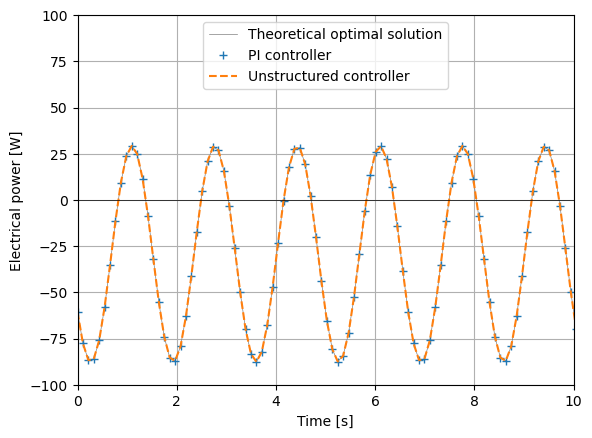

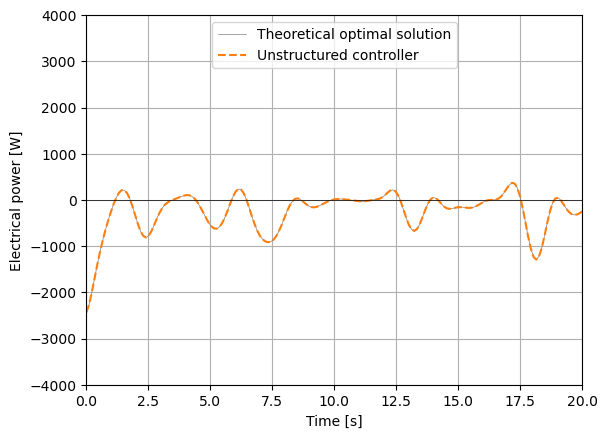

In [4]:
# Gains
B_wot, K_wot = verification_PI_regular['results'].x[-2:]
print(f'PI controller gains (theoretical): K = {K_cc:.1f} N/m, B = {B_cc:.1f} Ns/m')
print(f'PI controller gains (WecOptTool): K = {K_wot:.1f} N/m, B  {B_wot:.1f} Ns/m')

# Figure 4 (paper)
t_plot = 10
plt.figure()
plt.plot(time, cc_power_td_reg, '-', color='0.5', linewidth=0.5, label='Theoretical optimal solution')
plt.plot(time, verification_PI_regular['pto_tdom'].power, '+', label='PI controller')
plt.plot(time, verification_untructured_regular['pto_tdom'].power, '--', label='Unstructured controller')
plt.xlabel('Time [s]')
plt.ylabel('Electrical power [W]')
plt.legend(loc='upper center',)
plt.ylim([-100, 100])
plt.grid()
plt.xlim([0, t_plot])
plt.axhline(y=0, xmin = 0, xmax = 1, color = 'k', linewidth=0.5)

plt.savefig('IEEE_2023_verification_epower_reg.pdf')

# Figure 5 (paper)
plt.figure()
plt.plot(time, cc_power_td_irreg, '-', color='0.5', linewidth=0.5, label='Theoretical optimal solution')
plt.plot([],[])
plt.plot(time, verification_untructured_irregular['pto_tdom'].power, '--', label='Unstructured controller')
plt.xlabel('Time [s]')
plt.ylabel('Electrical power [W]')
plt.legend(loc='upper center',)
plt.ylim([-4000, 4000])
plt.grid()
plt.xlim([0, t_plot*2])
plt.axhline(y=0, xmin = 0, xmax = 1, color = 'k', linewidth=0.5)

plt.savefig('IEEE_2023_verification_epower_irreg.pdf')

## Section IV: Results
#### Section IV.A: Sea State Discretization

<div class="alert alert-block alert-warning">
<b>Correction:</b> In this study we did not normalize the data before using the k-means clustering. Normalizing is best practice, specially when dealing with data in different units or scales, unless a more informed distance function has been developed. Not normalizing is not "wrong" but corresponds to using a specific distance function different than the standard one with no good justification. This was a mistake. The effects of changing the distance function are not too great in this case since both sets of data have somewhat similar distributions.
</div>

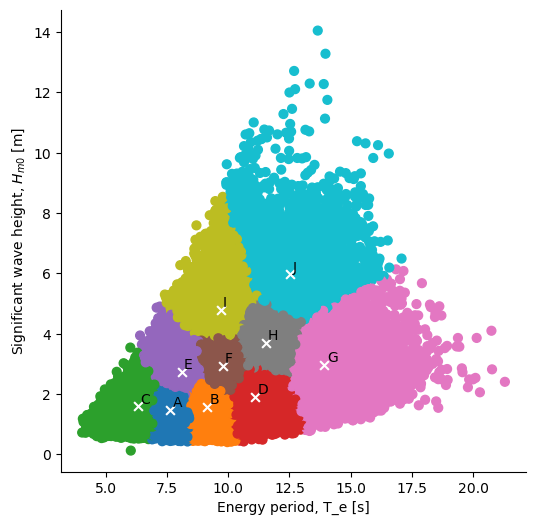

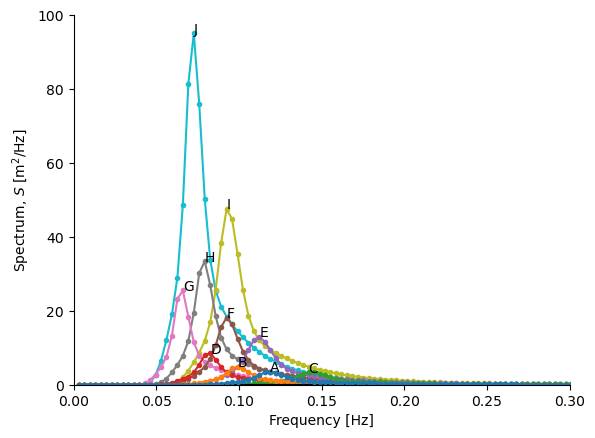

In [5]:
# obtain data
parameter = "swden"
buoy = "46050"
filenames = ndbc.available_data(parameter, buoy)
data = ndbc.request_data(parameter, filenames["filename"])
Hm0 = []
Te = []
Tp = []
for year in data:
    data[year] = ndbc.to_datetime_index(parameter, data[year])
    Hm0.append(mhkit.significant_wave_height(data[year].T))
    Te.append(mhkit.energy_period(data[year].T))
    Tp.append(mhkit.peak_period(data[year].T))
Hm0 = pd.concat(Hm0, axis=0)
Te = pd.concat(Te, axis=0)
Tp = pd.concat(Tp, axis=0)
data = pd.concat([Hm0, Te, Tp], axis=1).dropna().sort_index()

# clean data
data = data[data.Hm0<20]
data = data[data.index > datetime(1997, 1, 1)]

# clusters
N = 10
sea_states_labels = list(string.ascii_uppercase[0:N])
raster_order = -10
km = KMeans(n_clusters=N, random_state=1).fit(data[["Hm0", "Te"]])
weights = [(km.labels_ == i).sum() / len(km.labels_) for i in range(N)]
sea_states = pd.DataFrame(km.cluster_centers_, columns=["Hm0", "Te"])
rho = 1025
g = 9.81
sea_states["power"] =  (rho*g**2)/(64*np.pi)*(sea_states.Hm0**2)*sea_states.Te / 1000
sea_states["weight"] = weights
sea_states.sort_values("Hm0", inplace=True, ascending=True)
idx = sea_states.index
idx = [int(np.where(idx == i)[0]) for i in np.arange(N)]
idx = [idx[i] for i in km.labels_]
sea_states.reset_index(drop=True, inplace=True)

# representative sea state spectra (JONSWAP)
nfreq = 127
f1 = 0.42/nfreq

gamma = 3.3
waves = []
spectra = []
for i, sea_state in sea_states.iterrows():
    fp = 1 / mhkit.energy_period_to_peak_period(sea_state.Te, gamma)
    Hm0 = sea_state.Hm0
    spectrum = lambda f: wot.waves.jonswap_spectrum(f, fp, Hm0, gamma)
    efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "JONSWAP")
    wave = wot.waves.long_crested_wave(efth)
    wave.attrs['weight'] = sea_state.weight
    waves.append(wave)
    spectra.append(efth)

#Figure 5
cmap_qualitative = cm.tab10
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(data.Te, data.Hm0, c=idx, s=40, cmap=cmap_qualitative, rasterized=True)
ax.scatter(km.cluster_centers_[:, 1], km.cluster_centers_[:, 0], s=40, marker="x", color="w")
for x, y, lbl in zip(sea_states["Te"], sea_states.Hm0, sea_states_labels):
    plt.text(x+0.1, y+0.1, lbl)
ax.set_xlabel("Energy period, T_e [s]")
ax.set_ylabel("Significant wave height, " + "$H_{m0}$ [m]")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#Figure 6
plt.figure()
for i in range(len(waves))[::-1]:
    wave = waves[i]
    spectrum = spectra[i]
    f = wave.omega/(2*np.pi)
    plt.plot([f[0], f[-1]], [0, 0], "k-")
    plt.plot(f, spectrum, '-', color=cmap_qualitative.colors[i], marker='.')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    x = f[np.where(spectrum[:,0] == max(spectrum[:,0]))].values 
    y = max(spectrum.values)
    plt.text(x, y, sea_states_labels[i])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Spectrum, $S$ [m$^2$/Hz]')
    plt.xlim([0.0, 0.3])
    plt.ylim([0, 100])

#### Section IV.B: Optimal PTO for Annual Power
<div class="alert alert-block alert-info">
<b>Note:</b> This can take several hours.
</div>


PTO 1/98. m: 0.0, k:-15.0  sc_x_opt:0.01
  sea state: 0-A, exit mode: 0, nit: 18, avg. power: -621.99W
  sea state: 1-B, exit mode: 0, nit: 18, avg. power: -523.41W
  sea state: 2-C, exit mode: 0, nit: 16, avg. power: -971.19W
  sea state: 3-D, exit mode: 0, nit: 20, avg. power: -543.64W
  sea state: 4-E, exit mode: 0, nit: 16, avg. power: -1678.42W
  sea state: 5-F, exit mode: 0, nit: 16, avg. power: -1391.66W
  sea state: 6-G, exit mode: 0, nit: 17, avg. power: -823.33W
  sea state: 7-H, exit mode: 0, nit: 16, avg. power: -1650.38W
  sea state: 8-I, exit mode: 0, nit: 15, avg. power: -3006.23W
  sea state: 9-J, exit mode: 0, nit: 15, avg. power: -2966.92W
Average annual power: -1129.96W

PTO 2/98. m: 0.0, k:-10.0  sc_x_opt:0.01
  sea state: 0-A, exit mode: 0, nit: 17, avg. power: -587.55W
  sea state: 1-B, exit mode: 0, nit: 22, avg. power: -492.73W
  sea state: 2-C, exit mode: 0, nit: 17, avg. power: -919.34W
  sea state: 3-D, exit mode: 0, nit: 23, avg. power: -509.30W
  sea state

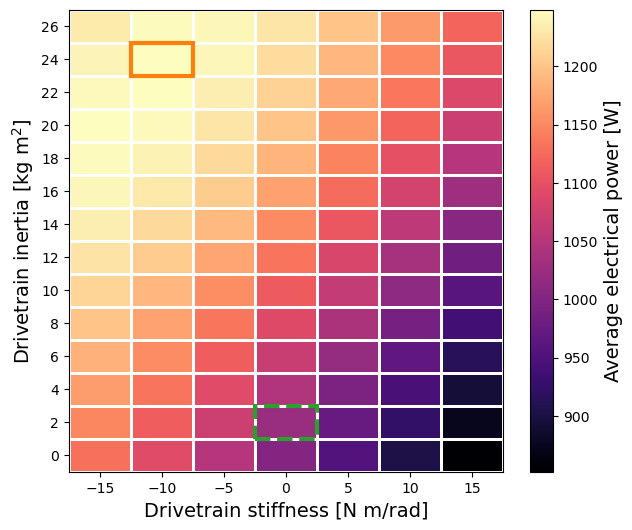

Optimal power 1248.6 
Nominal power 1023.8 
Improvement: 22.0%
Optimal configuration sea state power [ -796.  -654. -1191.  -662. -1749. -1514.  -902. -1742. -2827. -2886.]
Nominal configuration sea state power [ -539.  -447.  -851.  -457. -1531. -1265.  -704. -1507. -2908. -2914.]
Optimal config % improvement  [47.7 46.3 40.  44.9 14.2 19.7 28.1 15.6 -2.8 -1. ]
 # | Hm0 [m] | Te [s] | w [%] || Popt [W] | Pnom [W] | imp. [%]
  A,  1.48,  7.63,  19.6,  796,  539,  4670.0

  B,  1.58,  9.15,  14.9,  654,  447,  4530.0

  C,  1.58,  6.31,  15.8,  1191,  851,  3900.0

  D,  1.91,  11.11,  8.4,  662,  457,  4390.0

  E,  2.73,  8.10,  11.5,  1749,  1531,  1320.0

  F,  2.94,  9.77,  11.6,  1514,  1265,  1870.0

  G,  2.96,  13.93,  3.4,  902,  704,  2710.0

  H,  3.70,  11.53,  7.2,  1742,  1507,  1460.0

  I,  4.79,  9.69,  5.1,  2827,  2908,  -380.0

  J,  5.96,  12.54,  2.7,  2886,  2914,  -200.0


Annual 1249, - , - , - , 1024,  22.0



In [6]:
# frequency vector (NEW, same as wave spectra)
freq = wot.frequency(f1, nfreq, False)
omega = freq * 2*np.pi

# run Capytaine (BEM) 
bem_data = wot.run_bem(fb, freq)
hydro_data = wot.linear_hydrodynamics(bem_data, mass, stiffness)
Zi = wot.hydrodynamic_impedance(hydro_data).sel(influenced_dof='Heave', radiating_dof='Heave')
# create WEC object
wec = wot.WEC.from_bem(
    bem_data, 
    inertia_matrix=mass, 
    hydrostatic_stiffness=stiffness,
    constraints=None,
    friction=None,
    f_add=None,
)

# brute optimization parameter space
drivetrain_stiffness_list = np.linspace(-15, 15, 7)  # default: 0.0
drivetrain_inertia_list = np.linspace(0, 26, 14)  # default: 2.0   

def list_to_range(l1):
    if len(l1) >1:
        return slice(l1[0], l1[-1]+np.diff(l1)[0], np.diff(l1)[0])
    else:
        return slice(l1[0], 1.5*l1[0], l1[0])
ranges = (list_to_range(drivetrain_inertia_list), 
        list_to_range(drivetrain_stiffness_list),)

# outer optimization function
f_max = 8000.0
scale_x_opt = 1e-2
N = len(drivetrain_inertia_list) * len(drivetrain_stiffness_list)
sea_state_power = [[0]*len(waves) for i in range(N)] 

def outer_opt(x):
    #unpack optimization variables
    drivetrain_inertia = x[0]
    drivetrain_stiffness = x[1] 
    global count
    count +=1
    # PTO
    pto = wot.pto.PTO(
        fb.nb_dofs, 
        np.eye(fb.nb_dofs), 
        None, 
        pto_impedance(drivetrain_inertia, drivetrain_stiffness), 
        None, 
        ["PTO_Heave"],
    )
    # PTO force constraint constraints
    def const_f_pto(wec, x_wec, x_opt, waves):
        f = pto.force_on_wec(wec, x_wec, x_opt, waves, nsubsteps)
        return f_max - np.abs(f.flatten())
    wec.constraints = [{'type': 'ineq',
                        'fun': const_f_pto,
                        }]
    # WEC additional forces
    wec.forces['PTO'] = pto.force_on_wec
    # objective function
    objective = pto.average_power

    # run each sea state
    print(f"\nPTO {count}/{N}. m: {drivetrain_inertia:.1f}, k:{drivetrain_stiffness:.1f}",
          f" sc_x_opt:{scale_x_opt}")
    average_annual_power = 0
    for iw, wave in enumerate(waves):
        results = wec.solve(wave, objective, 2*nfreq+1, scale_x_opt=scale_x_opt, optim_options={"disp": False})
        avg_power = results.fun
        sea_state_power[count-1][iw] = avg_power
        average_annual_power = average_annual_power + avg_power * wave.weight
        print(f"  sea state: {iw}-{sea_states_labels[iw]}, " +
            f"exit mode: {results.status}, nit: {results.nit}, avg. power: {avg_power:.2f}W")
    print(f"Average annual power: {average_annual_power:.2f}W")
    return average_annual_power

# Solve 
count = 0
res = brute(func=outer_opt,
            args=(),
            ranges=ranges,
            full_output=True,
            finish=None)

# Plot 
fig, ax = plt.subplots(ncols=1, figsize=(7, 6))
(x, y, z)  = (res[2][1], res[2][0], -1*res[3])
pcm = ax.pcolormesh(x, y, z, cmap=cm.magma, edgecolor='w' )
ax.set_ylabel('Drivetrain inertia [kg m$^2$]', fontsize = 14)
ax.set_yticks(drivetrain_inertia_list)
ax.set_xlabel('Drivetrain stiffness [N m/rad]', fontsize = 14)
ax.set_xticks(drivetrain_stiffness_list)
pcb = fig.colorbar(pcm, ax=ax)
pcb.set_label('Average electrical power [W]', fontsize = 14)
wx = x[0,1]-x[0,0]  
wy = y[1,0] - y[0,0]
for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        if z[i, j] == -1*res[1]: #optimal 
            n_opt = i*z.shape[1] + j
            color = 'C1'
            ax.add_patch(plt.Rectangle((x[i,j]-wx/2, y[i,j]-wy/2), wx, wy, fc='none', ec=color, lw=3, clip_on=False))
        elif res[2][0][i,j] == 2 and res[2][1][i,j] == 0: #nominal configuration
            n_nominal = i*z.shape[1] + j
            P_nominal = z[i,j]
            color = 'C2'
            ax.add_patch(plt.Rectangle((x[i,j]-wx/2, y[i,j]-wy/2), wx, wy, fc='none', ec=color, lw=3, clip_on=False, linestyle = '--'))
plt.show()
print(f'Optimal power {-res[1]:.1f}', 
      f'\nNominal power {P_nominal:.1f}', 
      f'\nImprovement: {((-res[1]/P_nominal - 1) *100):.1f}%')

sea_state_power_optimal = np.round(sea_state_power[n_opt],0)
sea_state_power_nominal = np.round(sea_state_power[n_nominal],0)
sea_state_improvment = (np.round(sea_state_power_optimal/sea_state_power_nominal,3) - 1)*100

print(f'Optimal configuration sea state power {sea_state_power_optimal}'   )
print(f'Nominal configuration sea state power {sea_state_power_nominal}'   )
print(f'Optimal config % improvement  {sea_state_improvment}'   )


fig.savefig('IEEE_2023_power_contour_PS.pdf', bbox_inches='tight')

# Table II
# save in latex format
filename = "table_sea_state_power"
tmp = '\t'
with open(filename, "w") as f:
    for i, sea_state in sea_states.iterrows():
        f.write(" "*8 + f"{sea_states_labels[i]}  & {sea_state.Hm0:.2f} & {sea_state.Te:.2f} & {sea_state.weight*100:.1f} & {-sea_state_power_optimal[i]:.0f} & {-sea_state_power_nominal[i]:.0f} & {(sea_state_improvment[i] - 1)*100:.1f}  \\\\\n")
    f.write(" "*8 + f"\\bottomrule \n " + " "*8 + f"\\multicolumn{{4}}{{c||}}{{\\textbf{{Annual}}}} & \\textbf{{{-res[1]:.0f}}} & \\textbf{{{P_nominal:.0f}}} & \\textbf{{{((-res[1]/P_nominal - 1) *100):.1f}}} \\\\\n") 
# print
print(" # | Hm0 [m] | Te [s] | w [%] || Popt [W] | Pnom [W] | imp. [%]")
for i, sea_state in sea_states.iterrows():
    print(f"  {sea_states_labels[i]},  {sea_state.Hm0:.2f},  {sea_state.Te:.2f},  {sea_state.weight*100:.1f},  {-sea_state_power_optimal[i]:.0f},  {-sea_state_power_nominal[i]:.0f},  {(sea_state_improvment[i] - 1)*100:.1f}\n")
print(f"\nAnnual {-res[1]:.0f}, - , - , - , {P_nominal:.0f},  {((-res[1]/P_nominal - 1) *100):.1f}\n") 

### IV.B.1: Time Series Results

Optimization terminated successfully    (Exit mode 0)
            Current function value: -796.1307921068839
            Iterations: 23
            Function evaluations: 24
            Gradient evaluations: 23
Optimization terminated successfully    (Exit mode 0)
            Current function value: -539.1512097551908
            Iterations: 21
            Function evaluations: 22
            Gradient evaluations: 21


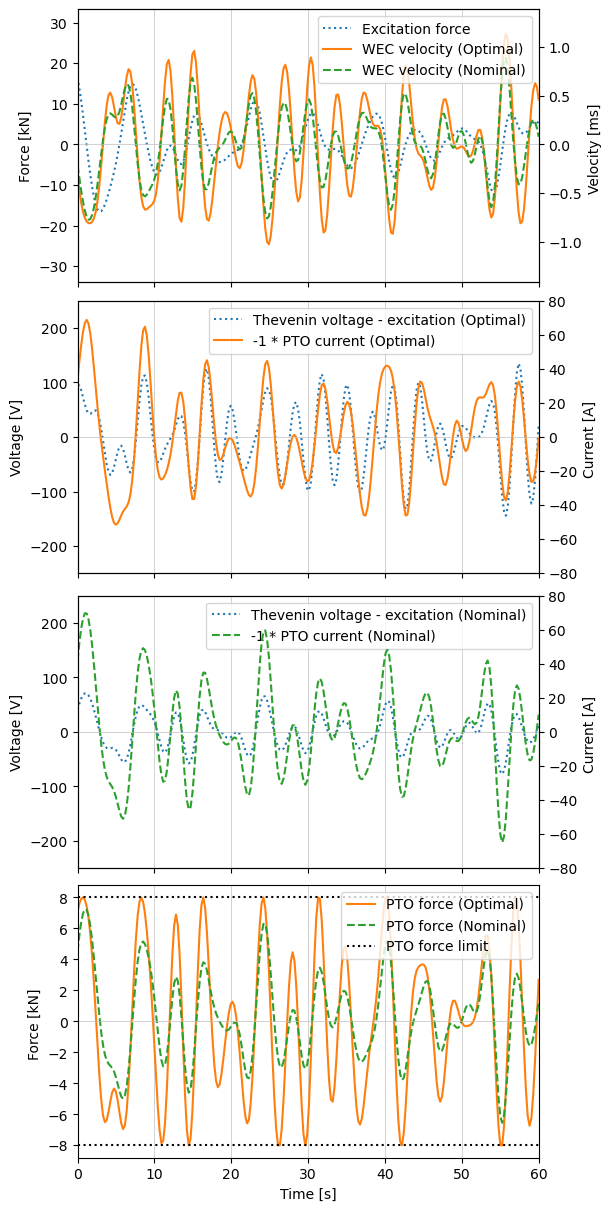

In [11]:
# solve nominal and optimal cases
def var_pto_solve(pto_impedance, scale_x_opt, waves):
    # PTO
    pto = wot.pto.PTO(
        fb.nb_dofs, 
        np.eye(fb.nb_dofs), 
        None, 
        pto_impedance, 
        None, 
        ["PTO_Heave"],
    )
    # WEC additional forces
    wec.forces['PTO'] = pto.force_on_wec
    # objective function
    objective = pto.average_power
    # optimal controller
    results = wec.solve(waves, objective, 2*nfreq+1, scale_x_opt=scale_x_opt)
    # post-process
    pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubsteps=nsubsteps)
    wec_fdom, wec_tdom = wec.post_process(results, waves, nsubsteps=nsubsteps)
    results = {
        'results': results,
        'pto_fdom': pto_fdom, 
        'pto_tdom': pto_tdom, 
        'wec_fdom': wec_fdom, 
        'wec_tdom': wec_tdom}
    return results

opt_pto_config = res[0].tolist()
pto_impedance_optimal = pto_impedance(*opt_pto_config)
pto_impedance_nominal = pto_impedance()
optimal_pto_irreg = var_pto_solve(pto_impedance_optimal, 1e-2,  waves[0])
nominal_pto_irreg = var_pto_solve(pto_impedance_nominal, 1e-2,  waves[0])

# post-process: current and voltage
def get_current_voltage(pto_impedance, res):
    pto = wot.pto.PTO(fb.nb_dofs, np.eye(fb.nb_dofs), None, pto_impedance, None, ["PTO_Heave"])
    x_wec, x_opt = wot.decompose_state(res.x, fb.nb_dofs, nfreq)
    q1_td = pto.velocity(wec, x_wec, x_opt, waves[0])
    e1_td = pto.force(wec, x_wec, x_opt, waves[0])
    q1 = wot.complex_to_real(wot.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wot.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wot.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(pto.transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2*pto.ndof)
    q2 = vars_2[:, :pto.ndof]
    e2 = vars_2[:, pto.ndof:]
    time_mat = pto._tmat(wec, nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return e2_td, q2_td, wot.real_to_complex(e2, True), wot.real_to_complex(q2, True)
voltage_nom_td, current_nom_td, voltage_nom_fd, current_nom_fd = get_current_voltage(pto_impedance_nominal, nominal_pto_irreg['results'])
voltage_opt_td, current_opt_td, voltage_opt_fd, current_opt_fd = get_current_voltage(pto_impedance_optimal, optimal_pto_irreg['results'])

# theoretical results
time = wec.time_nsubsteps(nsubsteps)
time_xr = xr.DataArray(time)

Fe_nom_irr_A = (nominal_pto_irreg['wec_fdom'].force.sel(type = 'Froude_Krylov') + 
        nominal_pto_irreg['wec_fdom'].force.sel(type = 'diffraction')).sel(influenced_dof = 'DOF_0')
Fe_opt_irr_A = (optimal_pto_irreg['wec_fdom'].force.sel(type = 'Froude_Krylov') + 
        optimal_pto_irreg['wec_fdom'].force.sel(type = 'diffraction')).sel(influenced_dof = 'DOF_0')

V_th_opt, Z_th_opt =  thevenin_equivalent(Zi,pto_impedance_optimal,Fe_opt_irr_A)
V_th_nom, Z_th_nom =  thevenin_equivalent(Zi,pto_impedance_nominal,Fe_nom_irr_A)

v_th_nom_td = wot.time_results(V_th_nom, time_xr)
v_th_opt_td = wot.time_results(V_th_opt, time_xr)
fe_nom_irr_A_td = wot.time_results(Fe_nom_irr_A, time_xr)
fe_opt_irr_A_td = wot.time_results(Fe_opt_irr_A, time_xr)

power_max = np.abs(Fe_nom_irr_A)**2 / (8* np.real(Zi))
epower_nom_max = np.abs(V_th_nom)**2 / (8* np.real(Z_th_nom))
epower_opt_max = np.abs(V_th_opt)**2 / (8* np.real(Z_th_opt))

# Plot
def align_yyaxis(ax1, ax2):
    ax1_ylims = ax1.axes.get_ylim()
    ax1_yratio = ax1_ylims[0] / ax1_ylims[1]
    ax2_ylims = ax2.axes.get_ylim()
    ax2_yratio = ax2_ylims[0] / ax2_ylims[1]
    if ax1_yratio < ax2_yratio: 
        ax2.set_ylim(bottom = ax2_ylims[1]*ax1_yratio)
    else:
        ax1.set_ylim(bottom = ax1_ylims[1]*ax2_yratio)

# plot
fig, ax = plt.subplots(nrows=4,
                       figsize=(6,12), sharex = True,
                       constrained_layout=True)

# subplot 1
line1 = ax[0].plot(time, fe_nom_irr_A_td/1000, ':', label='Excitation force')
ax[0].set_ylabel('Force [kN]')
ax0r = ax[0].twinx()
line2 = ax0r.plot(time, optimal_pto_irreg['wec_tdom'].vel.sel(influenced_dof = 'DOF_0'), 'C1', label = 'WEC velocity (Optimal)')
line3 = ax0r.plot(time, nominal_pto_irreg['wec_tdom'].vel.sel(influenced_dof = 'DOF_0'), 'C2', label = 'WEC velocity (Nominal)', linestyle='--')
ax0r.set_ylabel('Velocity [ms] ')
ax0r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(ax[0],ax0r)
lines = line1 + line2 + line3 
ax0r.legend(lines, ['Excitation force','WEC velocity (Optimal)', 'WEC velocity (Nominal)' ])
plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[0].grid(color='0.75', linestyle='-',
                     linewidth=0.5, axis = 'x')

# subplot 2
line1 = ax[1].plot(time, v_th_opt_td, 'C0', linestyle = 'dotted')
ax[1].set_ylabel('Voltage [V]')
ax1r = ax[1].twinx()
line2 = ax1r.plot(time, -1*current_opt_td, 'C1')
ax1r.set_ylabel('Current [A] ')
ax1r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(ax[1],ax1r)
lines = line1  + line2
ax[1].legend(lines, ['Thevenin voltage - excitation (Optimal)',
                     '-1 * PTO current (Optimal)'])
plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[1].grid(color='0.75', linestyle='-', linewidth=0.5, axis = 'x')
ax[1].set_ylim([-250, 250])
ax1r.set_ylim([-80, 80])

# subplot 3
line1 = ax[2].plot(time, v_th_nom_td, 'C0', linestyle = 'dotted')
ax[2].set_ylabel('Voltage [V]')
ax2r = ax[2].twinx()
line2 = ax2r.plot(time, -1*current_nom_td, 'C2', linestyle='--')
ax2r.set_ylabel('Current [A] ')
ax2r.tick_params(axis='y', color='black', labelcolor='black')
align_yyaxis(ax[2],ax2r)
lines =  line1 +line2 
ax[2].legend(lines, ['Thevenin voltage - excitation (Nominal)',
                     '-1 * PTO current (Nominal)'])
plt.axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[2].grid(color='0.75', linestyle='-', linewidth=0.5, axis = 'x')
ax[2].set_ylim([-250, 250])
ax2r.set_ylim([-80, 80])

# subplot 4
line1 = ax[3].plot(time, optimal_pto_irreg['pto_tdom'].force/1000, 'C1', label = 'PTO force (Optimal)')
line2 = ax[3].plot(time, nominal_pto_irreg['pto_tdom'].force/1000, 'C2', label = 'PTO force (Nominal)', linestyle='--')
ax[3].set_ylabel('Force [kN] ')
ax[3].axhline(y=8, linestyle=':', linewidth=1.5, color = 'k')
ax[3].legend(['PTO force (Optimal)', 'PTO force (Nominal)', 'PTO force limit'])
ax[3].axhline(y=-8, linestyle=':', linewidth=1.5, color = 'k')
ax[3].axhline(y=0, xmin = 0, xmax = 1, color = '0.75', linewidth=0.5)
ax[3].grid(color='0.75', linestyle='-', linewidth=0.5, axis = 'x')
ax[3].set_xlabel('Time [s]')
ax[3].set_xlim([0, 60])

fig.savefig('IEEE_2023_timeseries_SeaState_A_effort_flow.pdf', bbox_inches='tight')

### IV.B.2: Frequency Domain Results

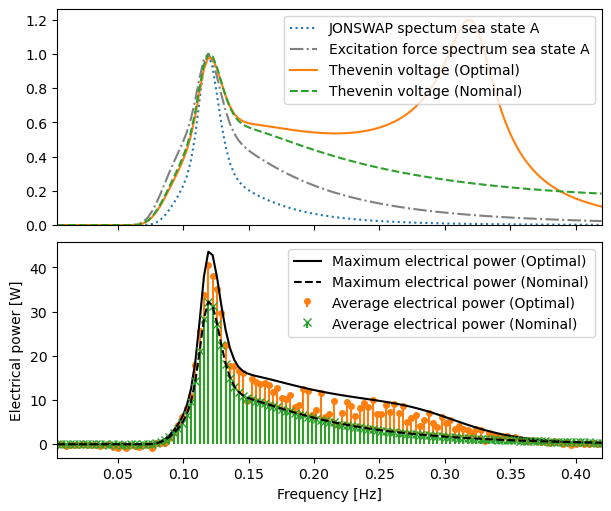

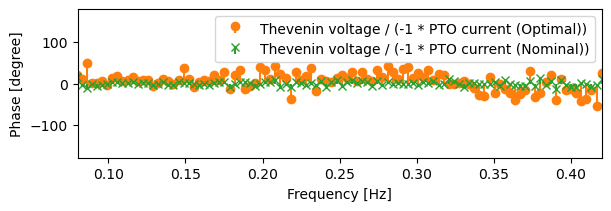

In [12]:
fig, ax = plt.subplots(nrows = 2, figsize=(6,5), constrained_layout=True, sharex= True)

# subplot 1
ax[0].plot(freq,spectra[0]/spectra[0].max(), linestyle = ':', label= f'JONSWAP spectum sea state {sea_states_labels[0]}')
Fe_irr_A = Fe_opt_irr_A  # Fe_nom_irr_A
ax[0].plot(freq,np.abs(Fe_irr_A[1:])/np.abs(Fe_irr_A).max(),  color ='grey', linestyle = '-.', label = f'Excitation force spectrum sea state {sea_states_labels[0]}' )
ax[0].plot(freq, np.abs(V_th_opt)/np.abs((V_th_opt).max()).squeeze(), label = 'Thevenin voltage (Optimal)', linestyle = '-')
ax[0].plot(freq, np.abs(V_th_nom)/np.abs((V_th_nom)).max().squeeze(), label = 'Thevenin voltage (Nominal)', linestyle = '--')
ax[0].set_ylabel('')
ax[0].set_ylim(bottom=0)
ax[0].set_title('')
ax[0].set_xlim(left=f1, right=f1*nfreq)
ax[0].legend(loc = 'upper right')

# subplot 2
markerline_opt, _, _, = ax[1].stem(freq,-0.5*np.real(np.conj(current_opt_fd[1:])*voltage_opt_fd[1:]), linefmt = "C1", markerfmt= 'C1o', label = 'Average electrical power (Optimal)', basefmt=" ")
ax[1].plot(freq,epower_opt_max.squeeze(),color = 'k',linestyle = '-', label = 'Maximum electrical power (Optimal)')
plt.setp(markerline_opt, markersize = 4)
markerline_nom, _, _, = ax[1].stem(freq,-0.5*np.real(np.conj(current_nom_fd[1:])*voltage_nom_fd[1:]), linefmt = "C2", markerfmt= 'C2x', label = 'Average electrical power (Nominal)', basefmt=" ")
plt.setp(markerline_nom, markersize = 6)
ax[1].plot(freq,epower_nom_max.squeeze(), 'k--', label = 'Maximum electrical power (Nominal)')

# labels
ax[0].set_xlabel('')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Electrical power [W]')
ax[1].legend()
fig.savefig('IEEE_2023_input_spectra.pdf', bbox_inches='tight')

# figure 2
fig, ax = plt.subplots(nrows=1, figsize=(6,2), sharex = True, constrained_layout=True)
ax.stem(freq, (np.angle(V_th_opt/(-1*current_opt_fd[1:, 0])))*180/np.pi, linefmt = "C1", 
        markerfmt= 'C1o', label = "Thevenin voltage / (-1 * PTO current (Optimal))", basefmt ='none')
ax.stem(freq, (np.angle(V_th_nom/(-1*current_nom_fd[1:, 0])))*180/np.pi, linefmt = "C2--", markerfmt= 'C2x', label = "Thevenin voltage / (-1 * PTO current (Nominal))", basefmt ='none')
ax.legend()
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Phase [degree]')
ax.set_xlim([0.08, 0.42])
ax.set_ylim([-180, 180])

fig.savefig('IEEE_2023_phase_matching.pdf', bbox_inches='tight')